# Multi-Class Prediction of Obesity Risk

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Carregando os Dados

In [104]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [105]:
# Salvar id para auxiliar na criação do arquivo que será enviado ao Kaggle
test_id = test['id']

# Criando um DF novo com o train e o test
df = pd.concat([train, test], ignore_index=True).drop('id', axis = 1)

# Para auxiliar no momento separar o DF em train e test
split_index = len(train)

# Variável alvo
target = df['NObeyesdad']
target_name = 'NObeyesdad'

## Análise Exploratória (EDA)

In [106]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [107]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,34598.000000,34598.000000,34598.000000,34598.000000,34598.000000,34598.000000,34598.000000,34598.000000
mean,23.886181,1.699721,87.686451,2.444704,2.757043,2.030469,0.978861,0.614467
std,5.733207,0.087895,26.273493,0.532568,0.707610,0.609566,0.839122,0.604475
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.784710,0.006892,0.000000
50%,22.851747,1.700000,84.000000,2.392179,3.000000,2.000000,1.000000,0.555591
75%,26.000000,1.761773,111.539494,3.000000,3.000000,2.550570,1.583832,1.000000
max,61.000000,1.980000,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34598 entries, 0 to 34597
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          34598 non-null  object 
 1   Age                             34598 non-null  float64
 2   Height                          34598 non-null  float64
 3   Weight                          34598 non-null  float64
 4   family_history_with_overweight  34598 non-null  object 
 5   FAVC                            34598 non-null  object 
 6   FCVC                            34598 non-null  float64
 7   NCP                             34598 non-null  float64
 8   CAEC                            34598 non-null  object 
 9   SMOKE                           34598 non-null  object 
 10  CH2O                            34598 non-null  float64
 11  SCC                             34598 non-null  object 
 12  FAF                             

In [109]:
df.nunique()

Gender                               2
Age                               1934
Height                            2070
Weight                            2318
family_history_with_overweight       2
FAVC                                 2
FCVC                              1054
NCP                                793
CAEC                                 4
SMOKE                                2
CH2O                              1734
SCC                                  2
FAF                               1539
TUE                               1436
CALC                                 4
MTRANS                               5
NObeyesdad                           7
dtype: int64

### Verificação de Nulos

In [110]:
columns_sum_nulls = df.isnull().sum()
columns_with_nulls = columns_sum_nulls[columns_sum_nulls > 0]
columns_with_nulls

NObeyesdad    13840
dtype: int64

### Análise de Correlação

#### Transformando algumas variaveis categoricas em numericas pra verificar correlação

In [111]:
numerical_data = df.select_dtypes(include=['float64', 'int64'])
categorical_data = df.select_dtypes(include=['object'])

In [112]:
df['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I', nan], dtype=object)

In [113]:
df['CAEC'].unique()

array(['Sometimes', 'Frequently', 'no', 'Always'], dtype=object)

In [114]:
df['CALC'].unique()

array(['Sometimes', 'no', 'Frequently', 'Always'], dtype=object)

In [115]:
map = {'no': 1,
       'Sometimes': 2, 
       'Frequently': 3,
       'Always': 4
       }
numerical_data['CAEC_N'] = df['CAEC'].map(map)
numerical_data['CALC_N'] = df['CALC'].map(map)

In [116]:
map = {'Insufficient_Weight': 1,
       'Normal_Weight': 2, 
       'Overweight_Level_I': 3,
       'Overweight_Level_II': 4,
       'Obesity_Type_I': 5,
       'Obesity_Type_II': 6,
       'Obesity_Type_III': 7
       }
numerical_data['NObeyesdad_N'] = df['NObeyesdad'].map(map)

#### Correlação entre Numéricas

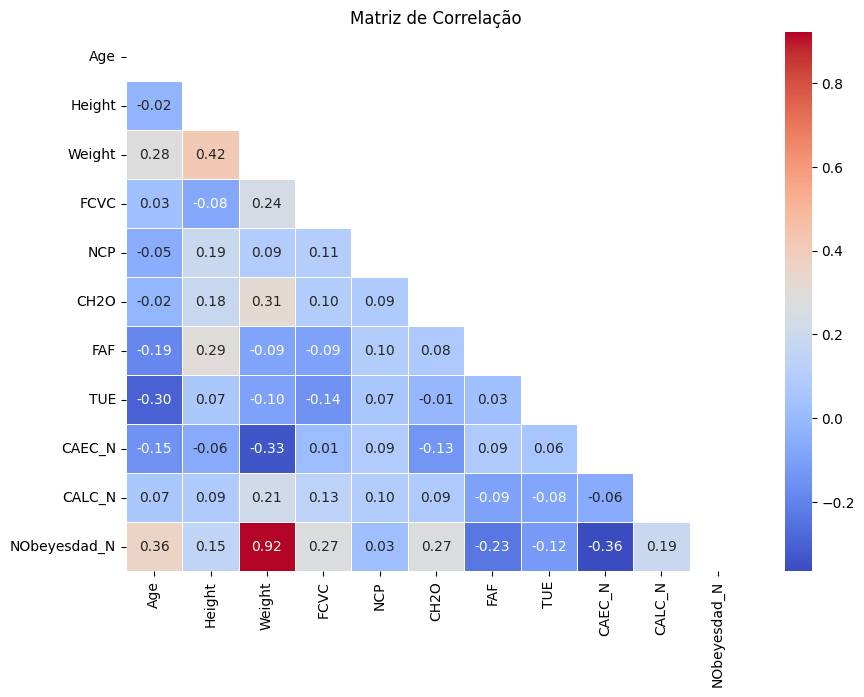

In [117]:
# Matriz de correlação
matriz_corr = numerical_data.corr()

# Plotar heatmap
plt.figure(figsize=(10, 7))
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
sns.heatmap(matriz_corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

#### Correlação entre Categóricas

In [118]:
import association_metrics as am

# Converter colunas pra category
df_category = categorical_data.apply(lambda x: x.astype("category"))

# Matriz de Cramers V para analisar a correlação das variaveis categóricas
cramersv = am.CramersV(df_category)
cramersv.fit()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
Gender,1.000000,0.098913,0.022441,0.074535,0.065381,0.059496,0.086237,0.152555,0.619004
family_history_with_overweight,0.098913,1.000000,0.151492,0.332593,0.017214,0.170507,0.009778,0.125480,0.556272
FAVC,0.022441,0.151492,1.000000,0.137244,0.019246,0.108906,0.114248,0.115920,0.273578
CAEC,0.074535,0.332593,0.137244,1.000000,0.029702,0.127772,0.079889,0.068360,0.332803
SMOKE,0.065381,0.017214,0.019246,0.029702,1.000000,0.020281,0.021024,0.032557,0.102079
SCC,0.059496,0.170507,0.108906,0.127772,0.020281,1.000000,0.011328,0.048256,0.222191
CALC,0.086237,0.009778,0.114248,0.079889,0.021024,0.011328,1.000000,0.064010,0.310908
MTRANS,0.152555,0.125480,0.115920,0.068360,0.032557,0.048256,0.064010,1.000000,0.168200
NObeyesdad,0.619004,0.556272,0.273578,0.332803,0.102079,0.222191,0.310908,0.168200,1.000000


In [119]:
numerical_data.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'CAEC_N', 'CALC_N', 'NObeyesdad_N'],
      dtype='object')

### Análise de Relações de Numéricas com a Variável Target

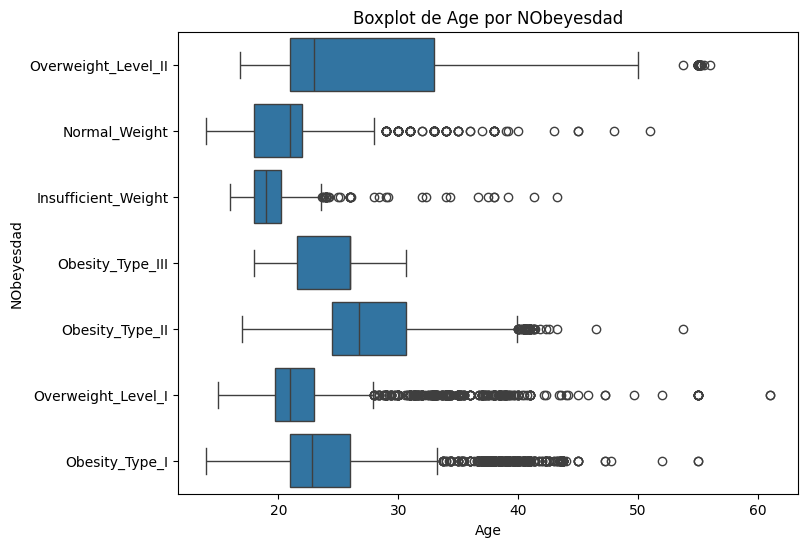

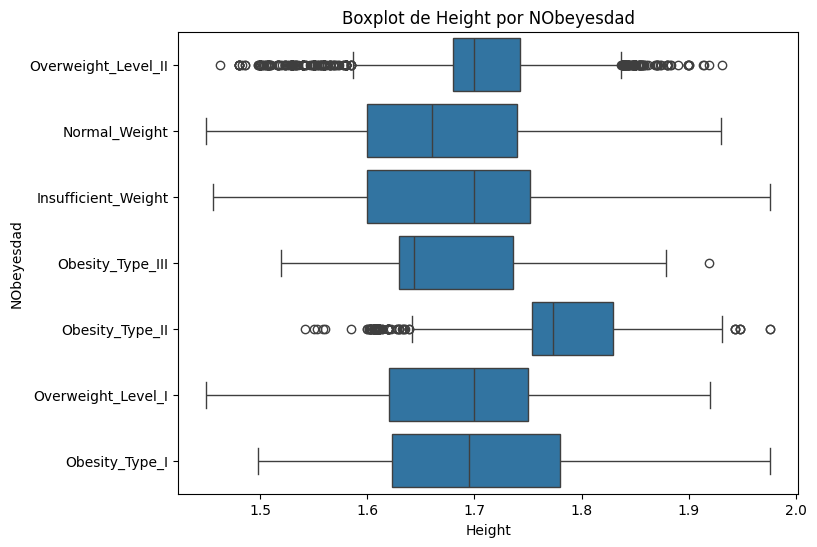

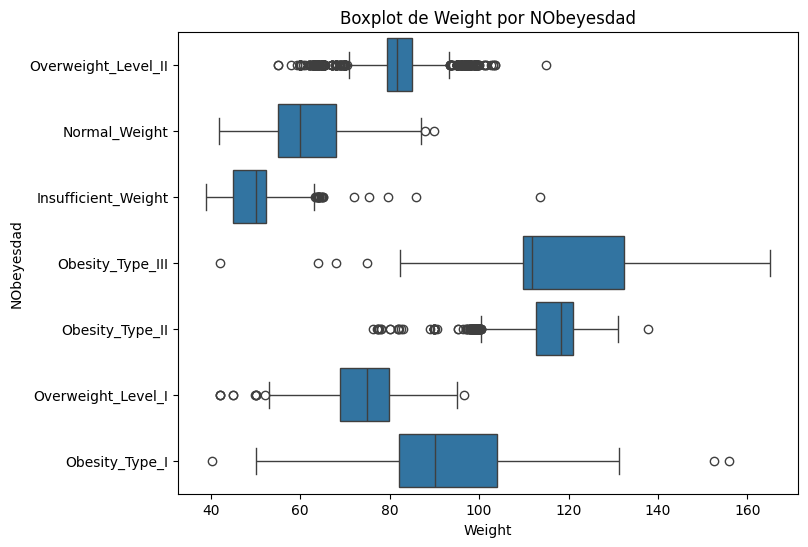

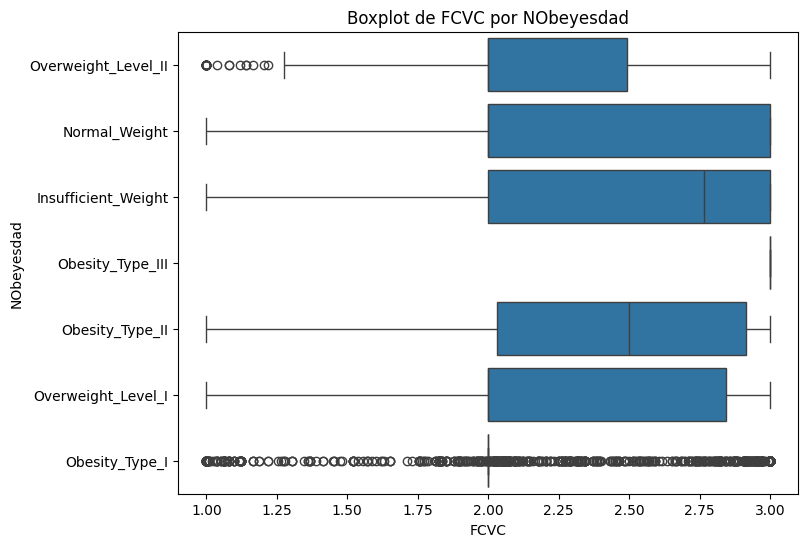

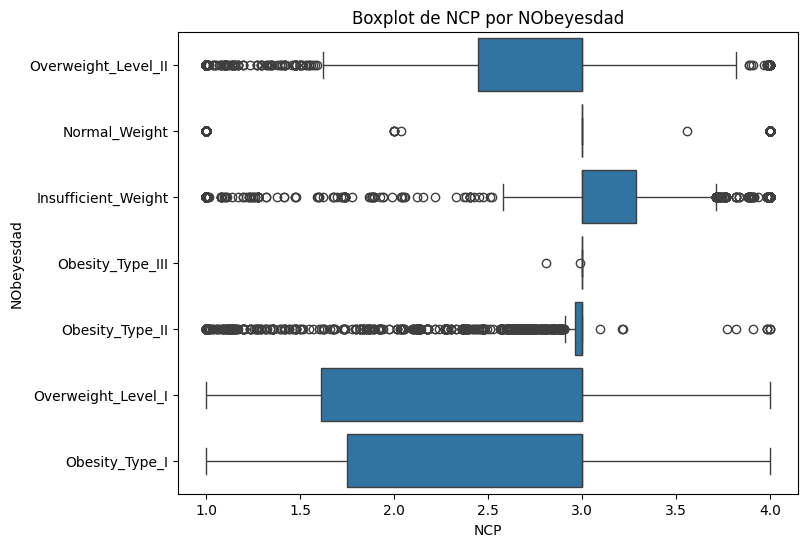

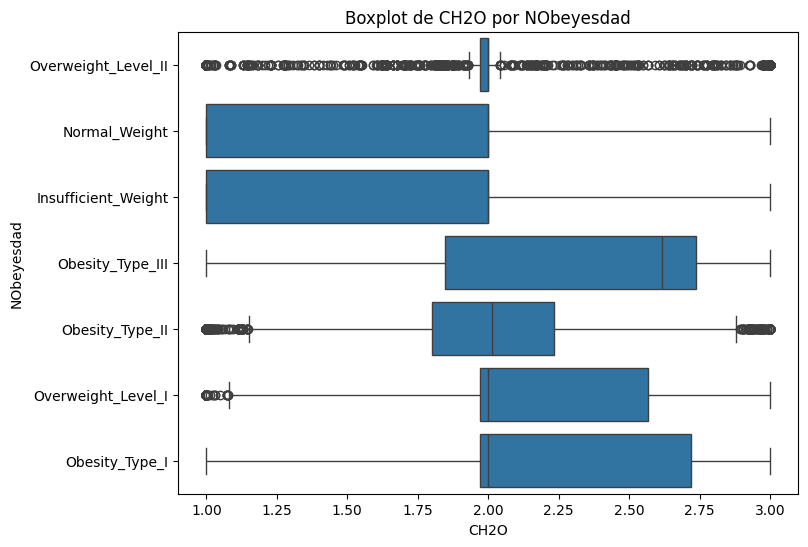

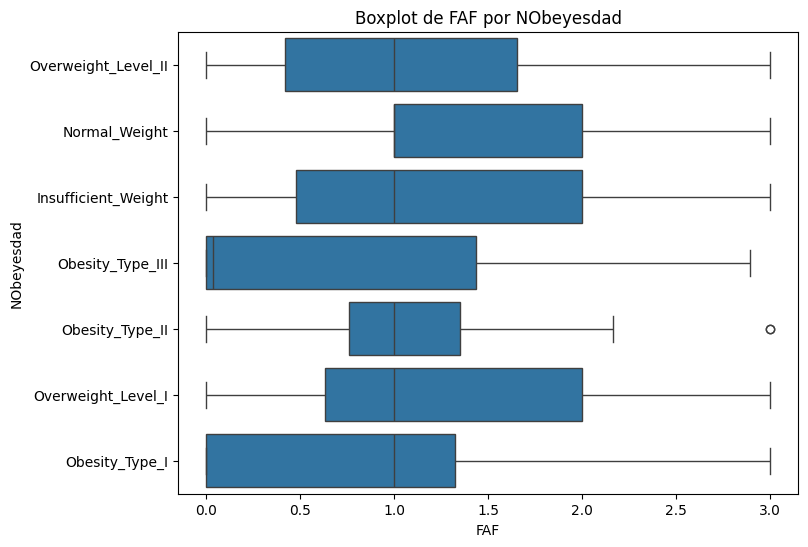

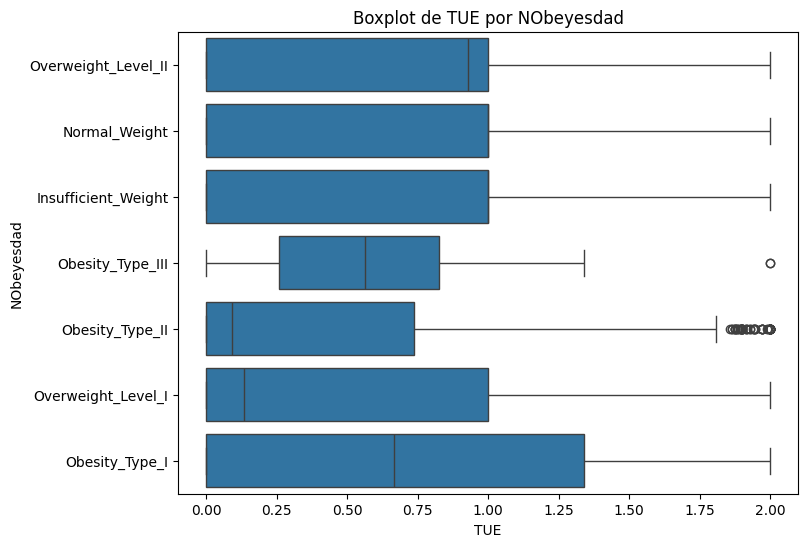

In [120]:
# Boxplots
for field in ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=field, y=target_name, data=df)
    plt.title(f'Boxplot de {field} por {target_name}')
    plt.show()

## Feature Engineering

In [121]:
df['IMC'] = df['Weight'] / ( df['Height'] * df['Height'] )
df = df.drop(['Height', 'Weight'], axis=1)

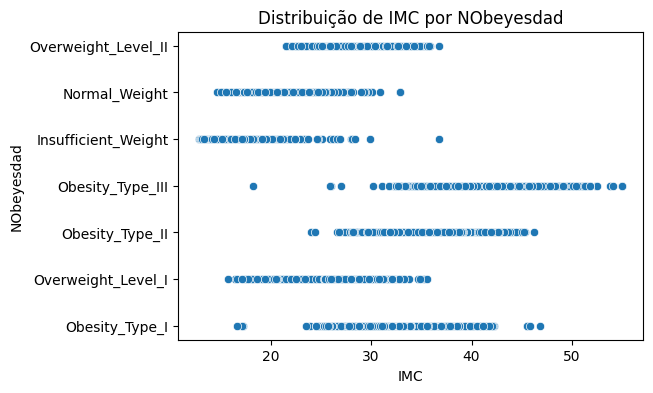

In [122]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='IMC', y=target, data=df)
plt.title(f'Distribuição de IMC por {target_name}')
plt.show()

### Removendo campos que não parecem ter muita correlação com o Target

In [123]:
df.drop(['SMOKE', 'TUE', 'FAF'], axis=1)

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,CALC,MTRANS,NObeyesdad,IMC
0,Male,24.443011,yes,yes,2.000000,2.983297,Sometimes,2.763573,no,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,Female,18.000000,yes,yes,2.000000,3.000000,Frequently,2.000000,no,no,Automobile,Normal_Weight,23.422091
2,Female,18.000000,yes,yes,1.880534,1.411685,Sometimes,1.910378,no,no,Public_Transportation,Insufficient_Weight,17.126706
3,Female,20.952737,yes,yes,3.000000,3.000000,Sometimes,1.674061,no,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,Male,31.641081,yes,yes,2.679664,1.971472,Sometimes,1.979848,no,Sometimes,Public_Transportation,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34593,Male,23.327836,yes,no,2.813234,3.000000,Sometimes,1.000000,no,Sometimes,Public_Transportation,NaN,26.333478
34594,Female,29.000000,no,yes,3.000000,3.000000,Sometimes,2.000000,no,Sometimes,Public_Transportation,NaN,24.524346
34595,Female,22.935612,no,yes,3.000000,2.273740,Frequently,2.000000,no,Sometimes,Public_Transportation,NaN,17.652091
34596,Male,21.000000,yes,yes,2.000000,3.000000,Sometimes,2.000000,no,no,Public_Transportation,NaN,20.195092


## Codificação One Hot de Variaveis Categoricas

In [124]:
one_hot_variables = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

In [125]:
# drop_first tira a primeira coluna, de forma que se as outras são zero, ela é a 'selecionada'
for variable in one_hot_variables:
    df = pd.get_dummies(df, columns=[variable], prefix=[variable], drop_first = True)

## Normalização

In [137]:
normalize_data = ['Age', 'IMC', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [138]:
scaler = StandardScaler() 

# Aplicar a normalização aos dados
df[normalize_data] = scaler.fit_transform(df[normalize_data])

In [139]:
df

,Age,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,IMC,Gender_Male,family_history_with_overweight_yes,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.097125,-0.835030,0.319748,1.202683,-1.166547,0.598886,Overweight_Level_II,-0.232830,True,True,...,False,False,False,False,True,False,False,False,True,False
1,-1.026697,-0.835030,0.343353,-0.049985,0.025192,0.637808,Normal_Weight,-0.814986,False,True,...,False,False,False,False,False,True,False,False,False,False
2,-1.026697,-1.059354,-1.901298,-0.197013,-0.134447,1.752153,Insufficient_Weight,-1.572591,False,True,...,False,False,False,False,False,True,False,False,True,False
3,-0.511666,1.042690,0.343353,-0.584699,0.582763,0.274179,Obesity_Type_III,1.764409,False,True,...,False,False,False,False,True,False,False,False,True,False
4,1.352648,0.441189,-1.110191,-0.083045,1.178764,0.524850,Overweight_Level_II,-0.552992,True,True,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34593,-0.097389,0.691996,0.343353,-1.690520,-0.204723,0.271587,NaN,-0.464621,True,True,...,False,False,False,False,True,False,False,False,True,False
34594,0.891978,1.042690,0.343353,-0.049985,-1.166547,-1.016544,NaN,-0.682337,False,False,...,False,False,False,False,True,False,False,False,True,False
34595,-0.165803,1.042690,-0.683018,-0.049985,1.157154,0.637808,NaN,-1.509364,False,False,...,False,False,False,False,True,False,False,False,True,False
34596,-0.503422,-0.835030,0.343353,-0.049985,2.408672,2.292160,NaN,-1.203332,True,True,...,False,False,False,False,False,True,False,False,True,False


## Modelagem

In [140]:
train = df[:split_index].copy()
test = df[split_index:].copy()

In [141]:
X_train = train.drop('NObeyesdad', axis = 1)
y_train = train['NObeyesdad']
X_test = test.drop('NObeyesdad', axis = 1)

### Selecionar modelo

In [142]:
# Lista de modelos a serem testados
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SGD Classifier': SGDClassifier(),
}

In [143]:
# Loop através dos modelos e imprime o desempenho usando validação cruzada
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{model_name} - Mean Accuracy: {np.mean(scores):.4f}")

Random Forest - Mean Accuracy: 0.8786
Logistic Regression - Mean Accuracy: 0.8529
Decision Tree - Mean Accuracy: 0.8170
K-Nearest Neighbors - Mean Accuracy: 0.7640
Naive Bayes - Mean Accuracy: 0.6636
Gradient Boosting - Mean Accuracy: 0.8839
SGD Classifier - Mean Accuracy: 0.7083


### Otimização de Hiperparâmetros

In [147]:
# Hiperparâmetros para ajustar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

In [148]:
gb = GradientBoostingClassifier()

grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy', verbose=20000)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 1/36] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.878 total time=  34.8s
[CV 2/5; 1/36] START max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 1/36] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.882 total time=  41.8s
[CV 3/5; 1/36] START max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 1/36] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.893 total time=  40.1s
[CV 4/5; 1/36] START max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 1/36] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.882 total time=  40.5s
[CV 5/5; 1/36] START max_depth=3, min_samples_leaf=1, min_samples_split=2, n_e

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=20000)

In [149]:
best_params = grid_search.best_params_
print(f"Best Hiperparameters: {best_params}")

Best Hiperparameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Treinar Modelo e obter Previsoes

In [150]:
# Treinando o modelo com os melhores hiperparâmetros no conjunto de treinamento completo
best_gb = GradientBoostingClassifier(**best_params)
best_gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=200)

In [151]:
# Fazer previsões no conjunto de testes
best_gb_pred = best_gb.predict(X_test)

## Comparação com Naive Bayes

## Matriz de Confusão

## Gerando Arquivo de Resultados para o Kaggle

In [152]:
kaggle = pd.DataFrame({'id': test_id, 'NObeyesdad': best_gb_pred})

In [159]:
kaggle.to_csv('prevision_obesity.csv', index = False)

In [160]:
kaggle

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight
